In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evaluate import load
import json


In [2]:
with open("../../experiments/interpolation-all_times-diffusion-rocstories-16-d=5-v1.0-ppl.json", "r") as f:
    ppl_v10 = json.load(f)

with open("../../experiments/interpolation-all_times-diffusion-rocstories-16-d=5-v2.3.4-ppl.json", "r") as f:
    ppl_v11 = json.load(f)


In [3]:
with open("../../experiments/interpolation-all_times-diffusion-rocstories-16-d=5-v2.3.4.json", "r") as f:
    texts_v11 = json.load(f)


In [4]:
texts_v11['0.0'].keys()

dict_keys(['alpha', 'pred_text', 'x_t_texts'])

In [5]:
selected_times = ['0.0', '0.1', '0.2', '0.3']

In [6]:
def filter_ppl(ppl_list):
    ppl_list = np.sort(ppl_list)
    quantile = 0.05
    a_min, a_max = int(quantile * len(ppl_list)), int((1 - quantile) * len(ppl_list))
    ppl_list = ppl_list[a_min: a_max]
    ppl = np.mean(ppl_list)
    return ppl

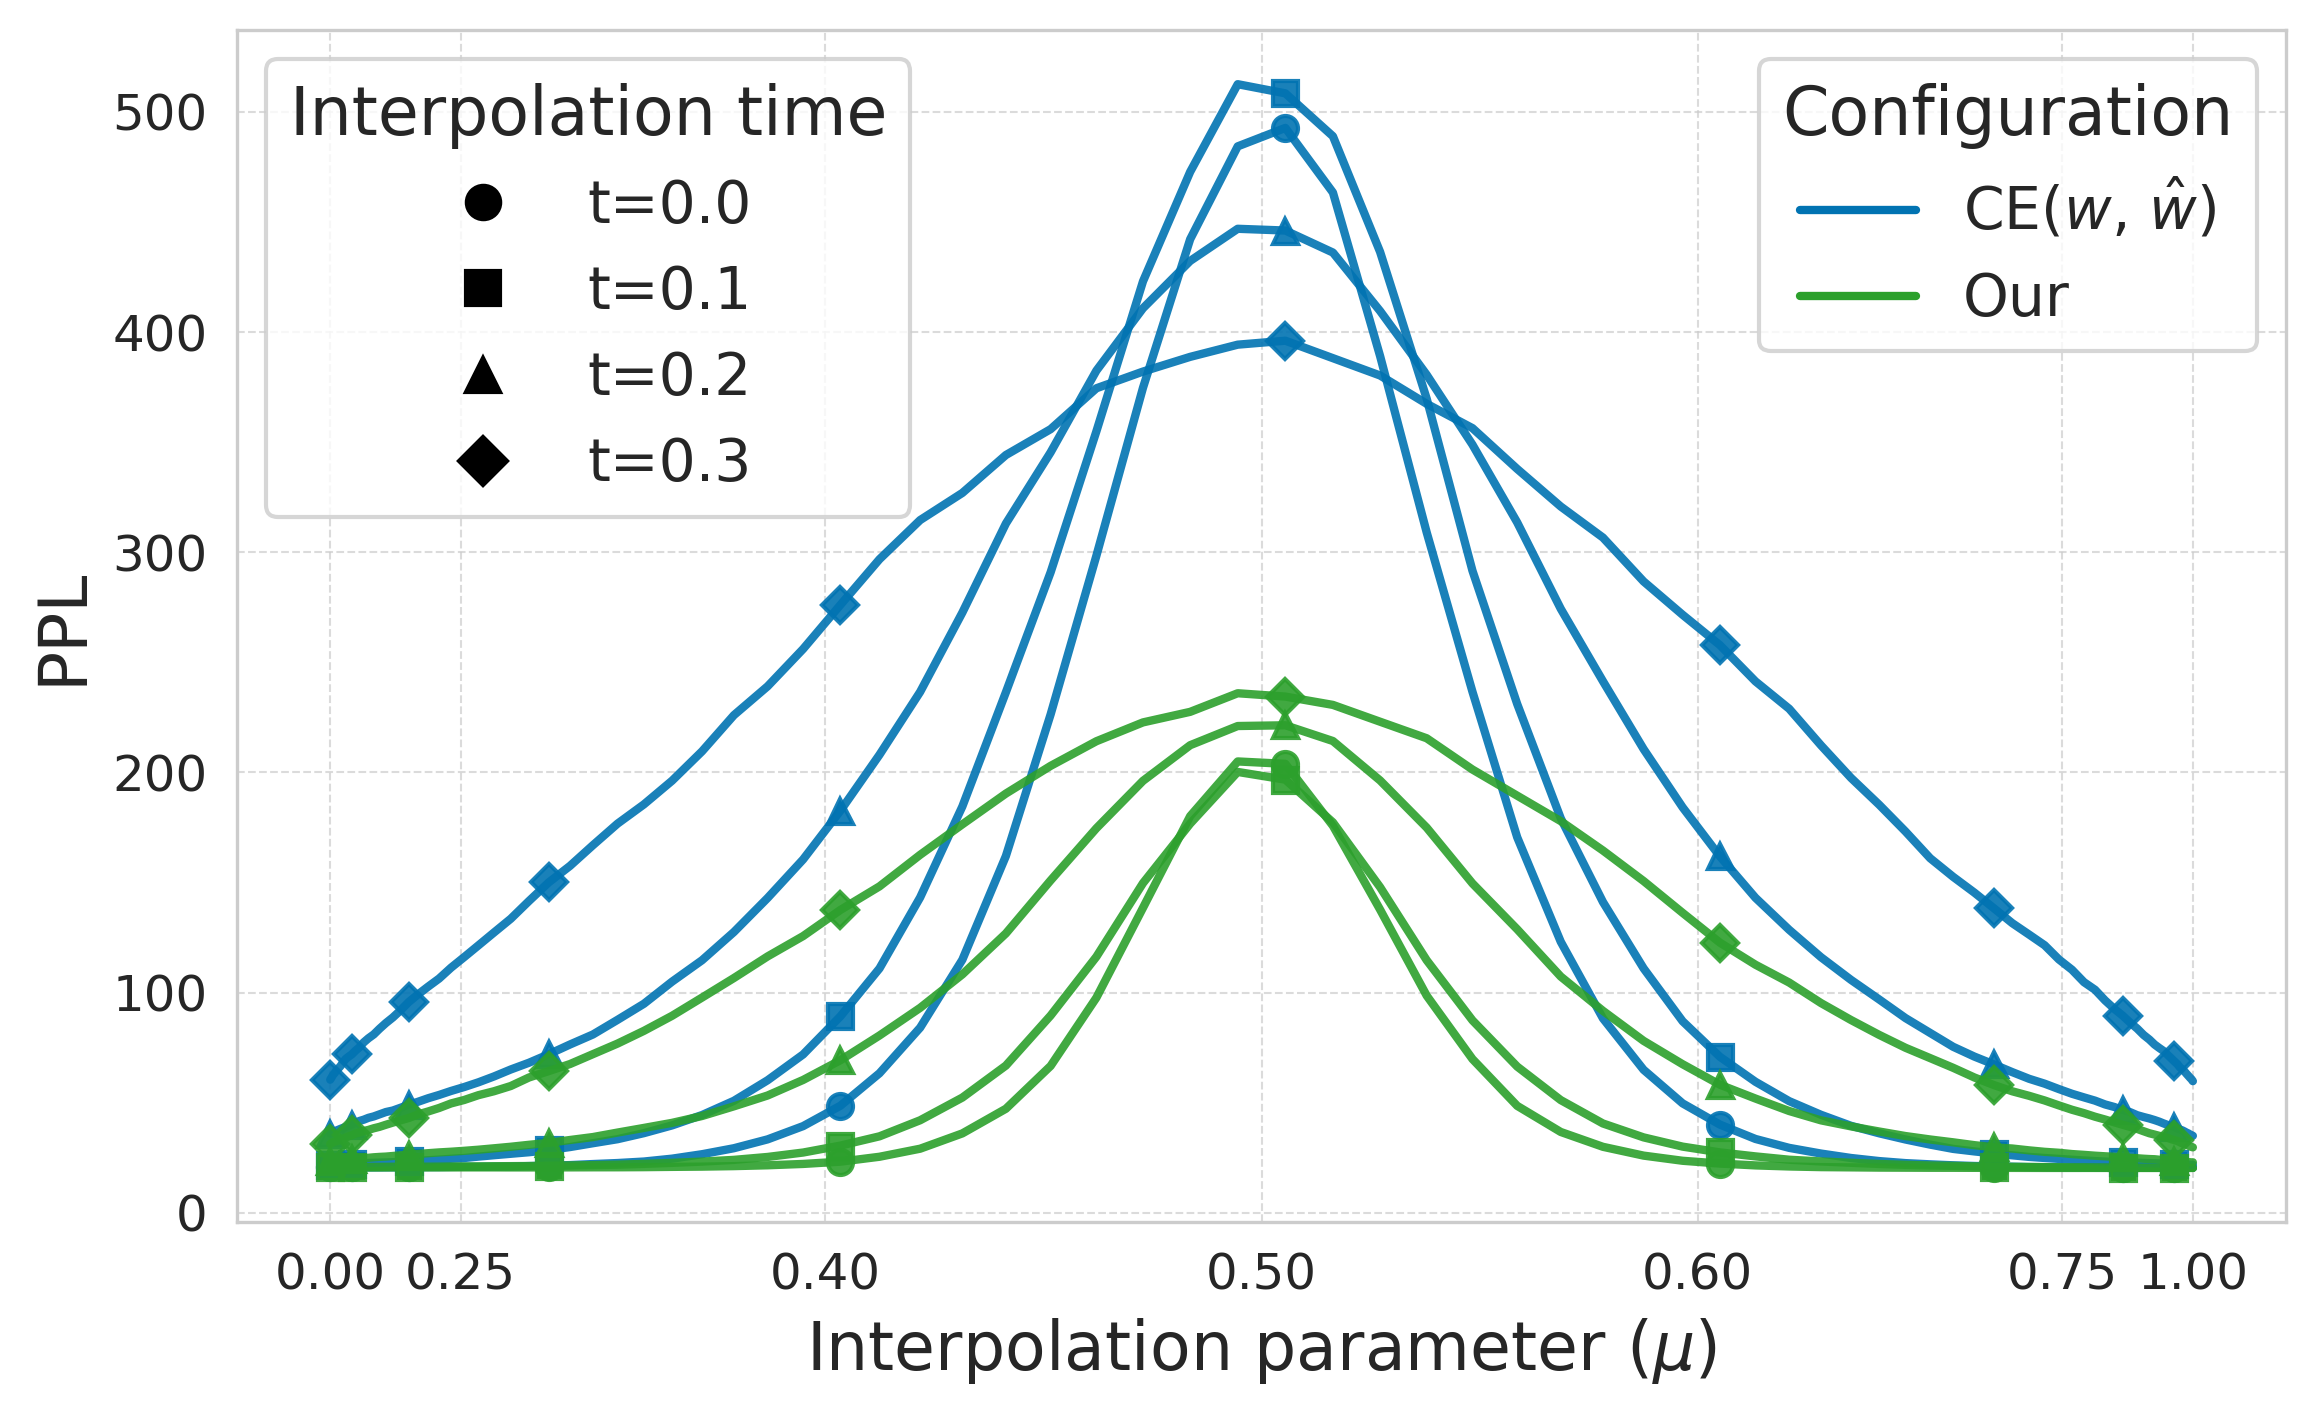

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# 1) Global styling
sns.set_style("whitegrid")
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial','Helvetica','DejaVu Sans'],
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 2.0,
    'figure.dpi': 300,
})

# 2) Vibrant, high-contrast colors and markers for t
v1_color = '#0173b2'   # vivid blue
v2_color = '#2ca02c'   # attractive green for v11
markers = ['o','s','^','D','v','<','>','p','*','X']  # up to 10 t-values
markevery = 10  # show a marker every 10 points

# 3) Figure
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# 4) Warp α → μ
alpha      = np.linspace(0, 1, 100)
c          = 10
alpha_warp = 1.0 / (1.0 + np.exp(-c * (alpha - 0.5)))

# 5) Plot each t with its own marker, color by version, rarer markers
for i, t in enumerate(selected_times):
    # CE(w, \hat w)
    perps10   = ppl_v10[t]
    avg_ppl10 = [filter_ppl(p) for p in perps10]
    ax.plot(alpha_warp, avg_ppl10,
            color=v1_color, linestyle='-', marker=markers[i],
            markevery=markevery, alpha=0.9)

    # Our configuration
    perps11   = ppl_v11[t]
    avg_ppl11 = [filter_ppl(p) for p in perps11]
    ax.plot(alpha_warp, avg_ppl11,
            color=v2_color, linestyle='-', marker=markers[i],
            markevery=markevery, alpha=0.9)

# 6) Axes, grid
ax.set_xlabel('Interpolation parameter ($\\mu$)')
ax.set_ylabel('PPL')
ax.grid(True, which='major', linestyle='--', alpha=0.7)

# 7) Legend for t (marker shapes)
t_handles = [
    Line2D([0],[0],
           color='black',
           marker=markers[i],
           linestyle='None',
           markersize=8,
           label=f't={t}')
    for i, t in enumerate(selected_times)
]
legend_t = ax.legend(handles=t_handles,
                     title='Interpolation time',
                     loc='upper left',
                     frameon=True)

# 8) Legend for version (colors & linestyles)
version_handles = [
    Line2D([0],[0], color=v1_color, lw=2, linestyle='-', label='CE($w$, $\\hat w$)'),
    Line2D([0],[0], color=v2_color, lw=2, linestyle='-', label='Our'),
]
legend_version = ax.legend(handles=version_handles,
                           title='Configuration',
                           loc='upper right',
                           frameon=True)

# re–add the first legend
ax.add_artist(legend_t)

# 9) Warp ticks back to original α
orig_ticks   = np.array([0.0,0.25,0.4,0.5,0.6,0.75,1.0])
warped_ticks = 1.0/(1.0+np.exp(-c*(orig_ticks-0.5)))
ax.set_xticks(warped_ticks)
ax.set_xticklabels([f'{t:.2f}' for t in orig_ticks])

# 10) Save & show
plt.tight_layout()
plt.savefig('smoothness.pdf', dpi=300, bbox_inches='tight')
plt.show()

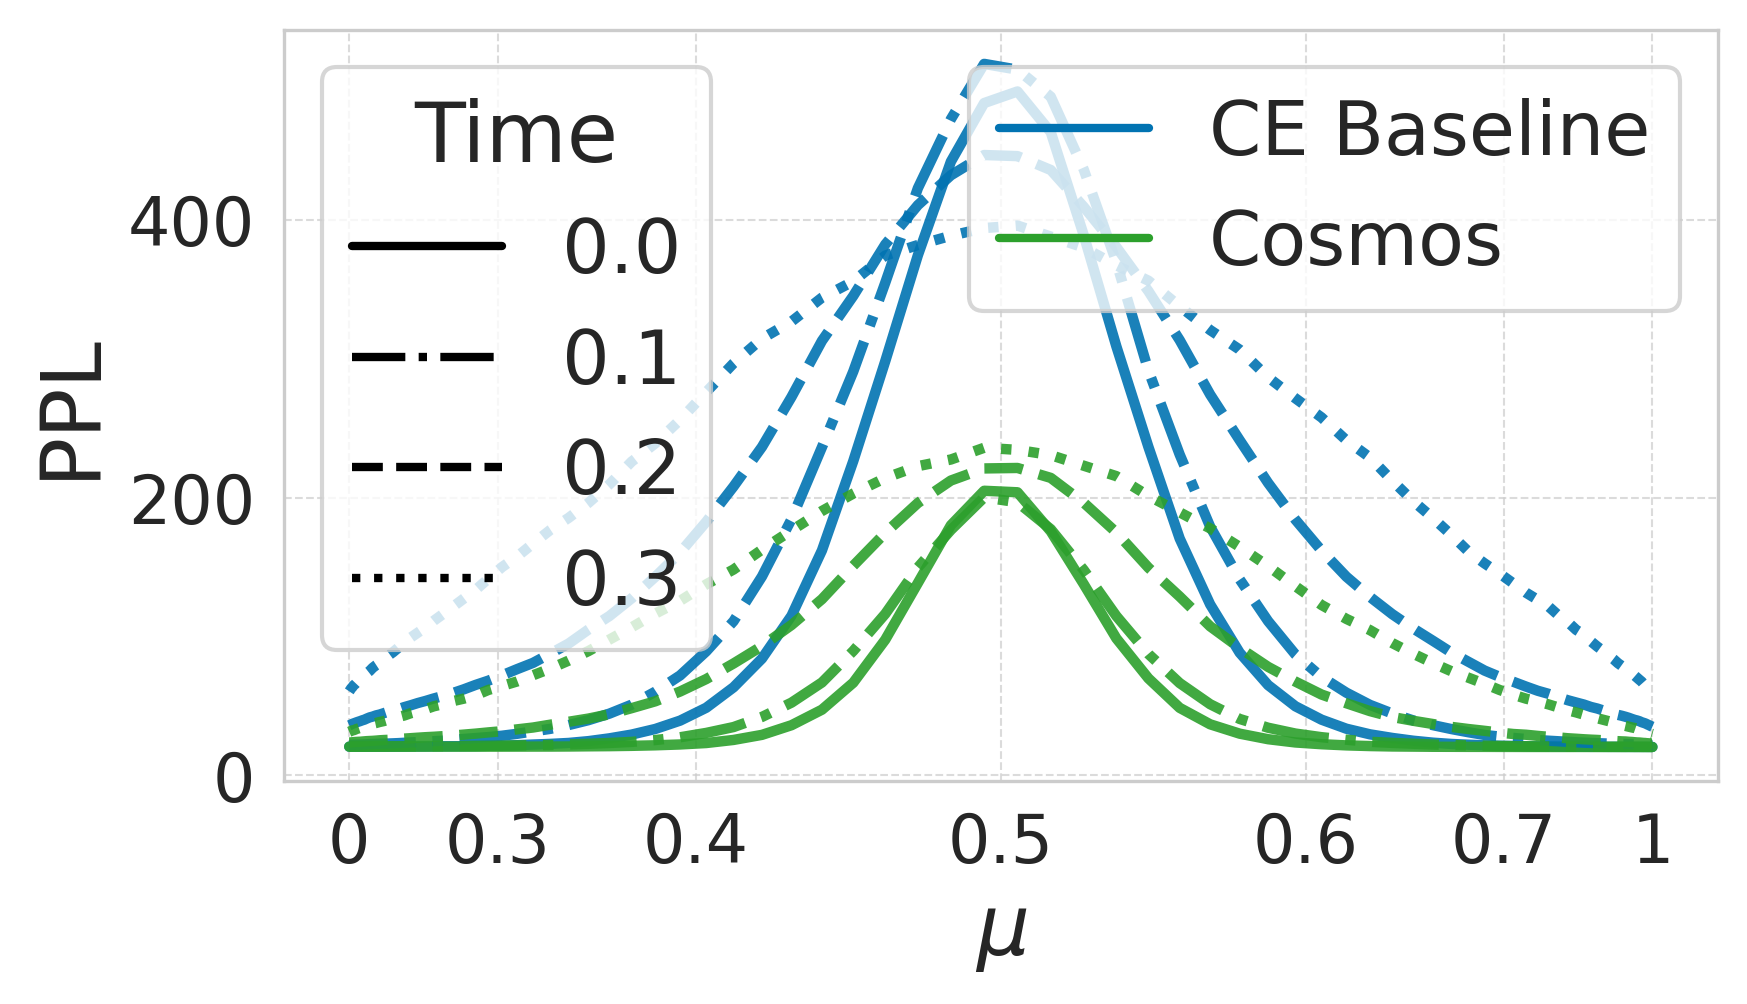

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# 1) Global styling
sns.set_style("whitegrid")
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 2.5,
    'figure.dpi': 300,
})

# 2) Colors and line styles for different interpolation times
v1_color    = '#0173b2'   # vivid blue
v2_color    = '#2ca02c'   # attractive green for v11
line_styles = ['solid', 'dashdot', 'dashed',  'dotted', (0, (3, 5, 1, 5))]

# 3) Figure
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# 4) Warp α → μ
alpha      = np.linspace(0, 1, 100)
c          = 10
alpha_warp = 1.0 / (1.0 + np.exp(-c * (alpha - 0.5)))

# 5) Plot each t with its own line style, color by version
for i, t in enumerate(selected_times):
    style = line_styles[i % len(line_styles)]
    # CE(w, \hat w)
    perps10   = ppl_v10[t]
    avg_ppl10 = [filter_ppl(p) for p in perps10]
    ax.plot(alpha_warp, avg_ppl10,
            color=v1_color, linestyle=style, alpha=0.9)
    # Our configuration
    perps11   = ppl_v11[t]
    avg_ppl11 = [filter_ppl(p) for p in perps11]
    ax.plot(alpha_warp, avg_ppl11,
            color=v2_color, linestyle=style, alpha=0.9)

# 6) Axes, grid
ax.set_xlabel('$\\mu$')
ax.set_ylabel('PPL')
ax.grid(True, which='major', linestyle='--', alpha=0.7)

# 7) Legend for t (line styles)
t_handles = [
    Line2D([0], [0],
           color='black',
           linestyle=line_styles[i % len(line_styles)],
           lw=2,
           label=f'{t}')
    for i, t in enumerate(selected_times)
]
legend_t = ax.legend(handles=t_handles,
                     title='Time',
                     loc='upper left',
                     frameon=True,
                     )

# 8) Legend for version (colors)
version_handles = [
    Line2D([0], [0], color=v1_color, lw=2, linestyle='-', label='CE Baseline'),
    Line2D([0], [0], color=v2_color, lw=2, linestyle='-', label='Cosmos'),
]
legend_version = ax.legend(handles=version_handles,
                        #    title='Configuration',
                           loc='upper right',
                           title_fontsize=20,
                           frameon=True)

# Re–add the first legend
ax.add_artist(legend_t)

# 9) Warp ticks back to original α
orig_ticks   = np.array([0.0,0.3,0.4,0.5,0.6,0.7,1.0])
warped_ticks = 1.0 / (1.0 + np.exp(-c * (orig_ticks - 0.5)))
ax.set_xticks(warped_ticks)
ax.set_xticklabels([f'{t:.1f}' if t not in [0.0, 1.0] else f'{t:.0f}' for t in orig_ticks])

# 10) Save & show
plt.tight_layout()
# Save the figure at a higher resolution (600 DPI) for publication quality
# Set figure size to 200×100 pixels at save DPI
width_px, height_px = 3500, 2000
save_dpi = 600
plt.gcf().set_size_inches(width_px / save_dpi, height_px / save_dpi)

plt.savefig('smoothness.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [15]:
selected_times = ['0.0', '0.1', '0.2', '0.3', '0.4',]

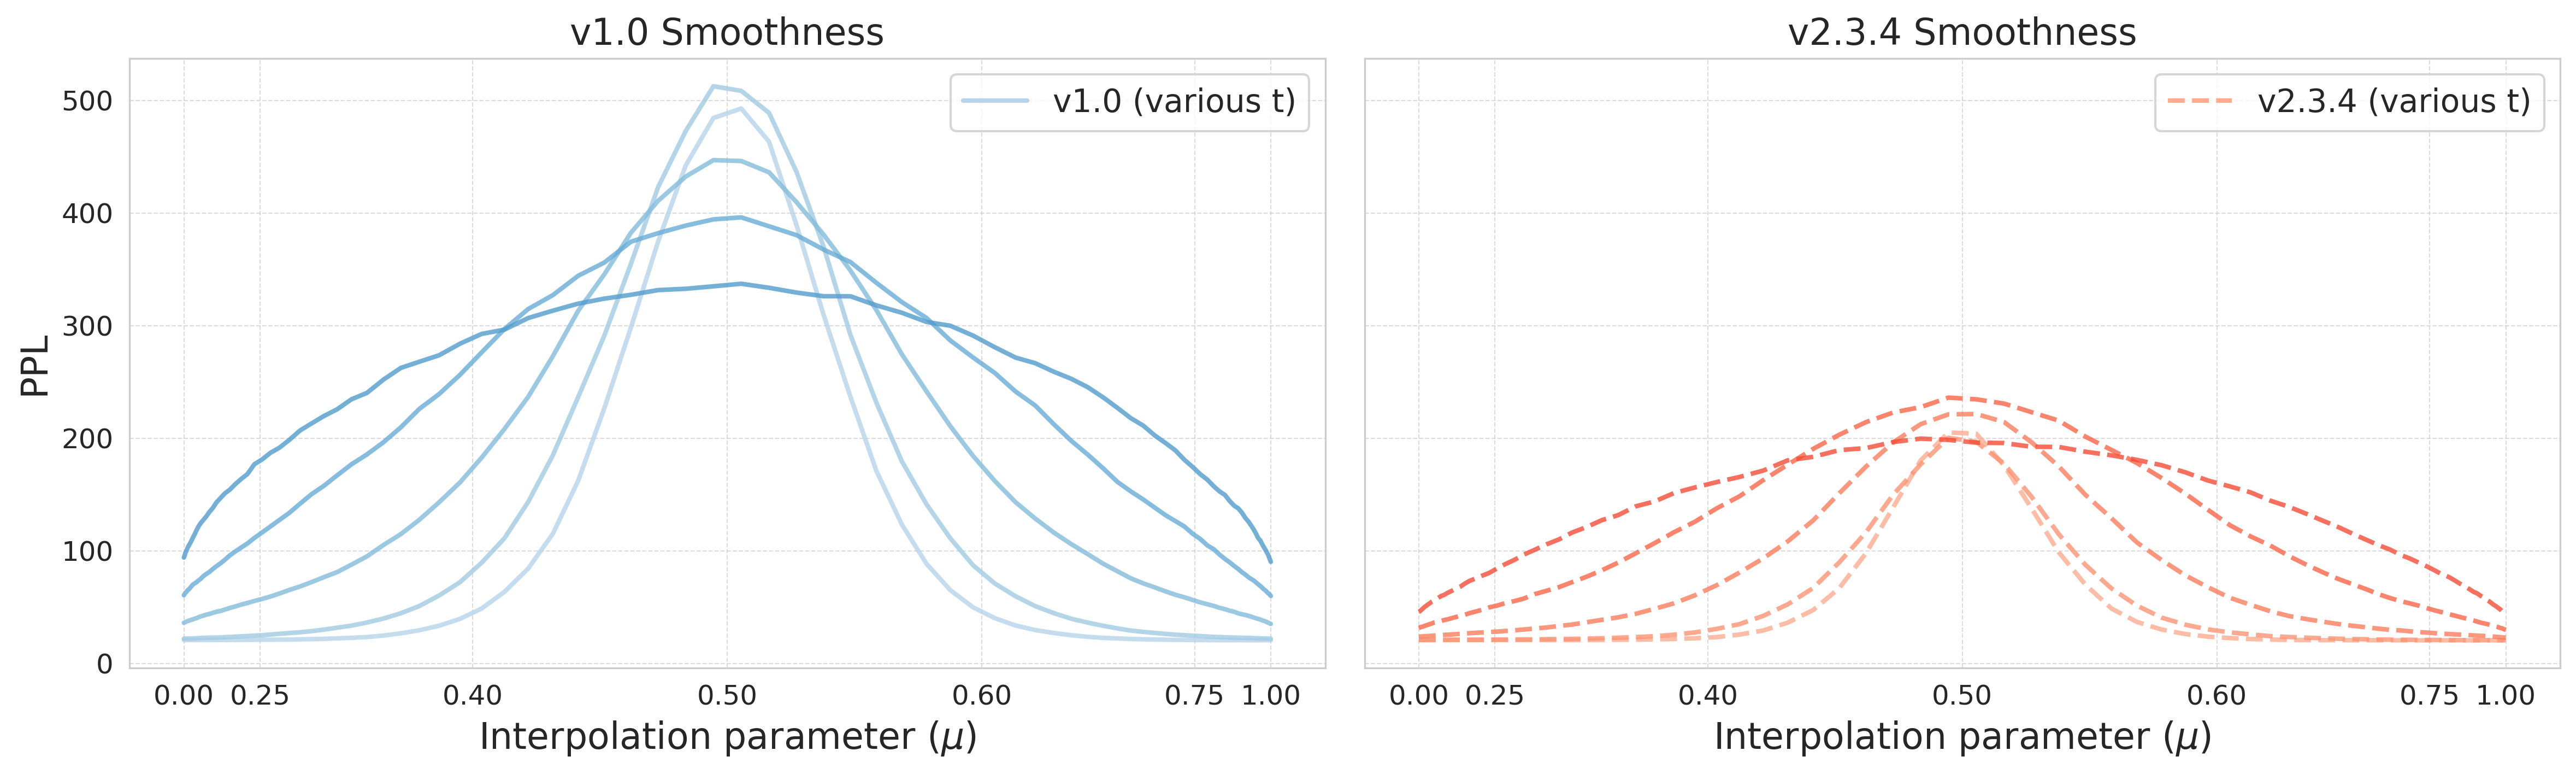

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Set the style for the plots
sns.set_style("whitegrid")
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 2.0,
    'figure.dpi': 300,
})

# Common definitions
alpha = np.linspace(0, 1, 100)
c = 10
alpha_warp = 1.0 / (1.0 + np.exp(-c * (alpha - 0.5)))

# Ticks for warped axis
orig_ticks = np.array([0.0, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0])
warped_ticks = 1.0 / (1.0 + np.exp(-c * (orig_ticks - 0.5)))

# Color maps for each version
v10_colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(ppl_v10)))
v11_colors = plt.cm.Reds(np.linspace(0.3, 1.0, len(ppl_v11)))

# Create two subplots side by side, sharing the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True, dpi=300)

# --- Plot for v1.0 ---
for i, (t, perps) in enumerate(sorted(ppl_v10.items())):
    if t not in selected_times:
        continue
    avg_ppl = [filter_ppl(p) for p in perps]
    ax1.plot(alpha_warp, avg_ppl,
             color=v10_colors[i], linestyle='-', alpha=0.8)
ax1.set_title('v1.0 Smoothness')
ax1.set_xlabel(r'Interpolation parameter ($\mu$)')
ax1.set_ylabel('PPL')
ax1.grid(True, which='major', linestyle='--', alpha=0.7)
# Custom legend for v1.0
legend_v10 = [
    plt.Line2D([0], [0],
               color=v10_colors[0], lw=2, linestyle='-',
               label='v1.0 (various t)')
]
ax1.legend(handles=legend_v10, loc='upper right')
ax1.set_xticks(warped_ticks)
ax1.set_xticklabels([f'{t:.2f}' for t in orig_ticks])

# --- Plot for v2.3.4 ---
for i, (t, perps) in enumerate(sorted(ppl_v11.items())):
    if t not in selected_times:
        continue
    avg_ppl = [filter_ppl(p) for p in perps]
    ax2.plot(alpha_warp, avg_ppl,
             color=v11_colors[i], linestyle='--', alpha=0.8)
ax2.set_title('v2.3.4 Smoothness')
ax2.set_xlabel(r'Interpolation parameter ($\mu$)')
ax2.grid(True, which='major', linestyle='--', alpha=0.7)
# Custom legend for v2.3.4
legend_v11 = [
    plt.Line2D([0], [0],
               color=v11_colors[0], lw=2, linestyle='--',
               label='v2.3.4 (various t)')
]
ax2.legend(handles=legend_v11, loc='upper right')
ax2.set_xticks(warped_ticks)
ax2.set_xticklabels([f'{t:.2f}' for t in orig_ticks])

plt.tight_layout()
plt.savefig('smoothness.pdf', dpi=300, bbox_inches='tight')
plt.show()